In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from keras.metrics import mse
import matplotlib.pyplot as plt
from keras.backend import set_session
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D, UpSampling2D, Input, Lambda, multiply, Input, concatenate
from keras.layers import LeakyReLU
from PIL import Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def ChangeImage(image, dim=32):
    x_cutting = image.size[0] - image.size[0] % dim
    y_cutting = image.size[1] - image.size[1] % dim

    a = (image.size[0] - x_cutting) // 2
    b = (image.size[1] - y_cutting) // 2
    c = (image.size[0] + x_cutting) // 2
    d = (image.size[1] + y_cutting) // 2

    cropped_image = img_to_array(image.crop([a,b,c,d]))
    cropped_image = (np.expand_dims(cropped_image, axis=0).astype('float32'))/255
    return cropped_image

In [ ]:
class Hourglass:
    def __init__(self, input_size, input_channel, output_channel, nu, nd, ns, ku, kd, ks, upsample_type='bilinear'):
        self.in_size = input_size
        self.in_channel = input_channel
        self.out_channel = output_channel
        self.nu = nu
        self.nd = nd
        self.ns = ns
        self.ku = ku
        self.kd = kd
        self.ks = ks
        self.upsample_type = upsample_type
        self.use_bias = True

    def up_sample(self, x, size=2):
        index = x.shape
        new_w = int(round(index[1] * size))
        new_h = int(round(index[2] * size))
        return tf.image.resize(x, [new_w, new_h], method=tf.image.ResizeMethod.BILINEAR)

    def down(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=2, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    
    def skip(self, x, n, k, use_bias=True):
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        return x

    def up(self, x, n, k, upsample_mode, use_bias=True):
        x = BatchNormalization()(x)
        pad_size = int((k - 1) / 2)
        x = tf.pad(x, paddings=[[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')
        x = Conv2D(n, k, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(n, 1, strides=1, use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = self.up_sample(x, 2)
        return x
    
    def model_structure(self):
        width, height = self.in_size
        input = Input((width, height, self.in_channel))
        x = input
        n = 5
        skips = []
        x = self.down(x, self.nd[0], self.kd[0], self.use_bias)
        if self.ns[0] != 0:
            skip = self.skip(x, self.ns[0], self.ks[0], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[1], self.kd[1], self.use_bias)
        if self.ns[1] != 0:
            skip = self.skip(x, self.ns[1], self.ks[1], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[2], self.kd[2], self.use_bias)
        if self.ns[2] != 0:
            skip = self.skip(x, self.ns[2], self.ks[2], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[3], self.kd[3], self.use_bias)
        if self.ns[3] != 0:
            skip = self.skip(x, self.ns[3], self.ks[3], self.use_bias)
            skips.append(skip)
        x = self.down(x, self.nd[4], self.kd[4], self.use_bias)
        if self.ns[4] != 0:
            skip = self.skip(x, self.ns[4], self.ks[4], self.use_bias)
            skips.append(skip)

        x = self.up(x, self.nu[4], self.ku[4], self.upsample_type, self.use_bias)
        skips = skips[::-1]
        x = self.up(x, self.nu[3], self.ku[3],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[2]], axis=-1)
        x = self.up(x, self.nu[2], self.ku[2],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[3]], axis=-1)
        x = self.up(x, self.nu[1], self.ku[1],self.upsample_type, self.use_bias)
        x = concatenate([x, skips[4]], axis=-1)
        x = self.up(x, self.nu[0], self.ku[0],self.upsample_type, self.use_bias)

        output = Conv2D(self.out_channel, 1, activation='sigmoid')(x)

        model = Model(inputs=input, outputs=output)
        return model

In [ ]:
def plot_losses(train_loss, image_title):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(image_title)
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.show()

In [ ]:
import os
import glob

folder_path = "./drive/MyDrive/SMAI_Project"  # replace with your folder path

file_list = []
for file_path in glob.glob(os.path.join(folder_path, "*")):
    file_list.append(file_path)
print(file_list)

['./drive/MyDrive/SMAI_Project/pepper.png', './drive/MyDrive/SMAI_Project/coastguard.png', './drive/MyDrive/SMAI_Project/man.png', './drive/MyDrive/SMAI_Project/bridge.png', './drive/MyDrive/SMAI_Project/face.png', './drive/MyDrive/SMAI_Project/ppt3.png', './drive/MyDrive/SMAI_Project/foreman.png', './drive/MyDrive/SMAI_Project/flowers.png', './drive/MyDrive/SMAI_Project/zebra.png', './drive/MyDrive/SMAI_Project/comic.png', './drive/MyDrive/SMAI_Project/monarch.png', './drive/MyDrive/SMAI_Project/baboon.png', './drive/MyDrive/SMAI_Project/barbara.png', './drive/MyDrive/SMAI_Project/lenna.png', './drive/MyDrive/SMAI_Project/zebra', './drive/MyDrive/SMAI_Project/pepper', './drive/MyDrive/SMAI_Project/coastguard', './drive/MyDrive/SMAI_Project/man']


In [ ]:
def model_obj(x):
  b, w, h, c = x.shape

  ### build model
  layers = Hourglass((w, h), input_channel, c,
                        nu=[128, 128, 128, 128, 128],
                        nd=[128, 128, 128, 128, 128],
                        ns=[4, 4, 4, 4, 128],
                        ku=[3, 3, 3, 3, 3],
                        kd=[3, 3, 3, 3, 3],
                        ks=[1, 1, 1, 1, 1],
                        upsample_type='bilinear'
                        )
  
  return layers

In [ ]:
def resize_image(image, w2, h2):
    """
    Resizes the input image to have dimensions w2 x h2, by adding white pixels if necessary.
    
    Args:
        image: A PIL Image object.
        w2: The desired width of the resized image.
        h2: The desired height of the resized image.
        
    Returns:
        A resized PIL Image object.
    """
    # Get the original width and height of the image
    print("Hello")
    w1, h1 = image.size
    
    # If the image is already the desired size, return it unchanged
    if w1 == w2 and h1 == h2:
        image.save('./mask.png')
        return image
    
    # Create a new blank image with the desired size and fill it with white
    new_image = Image.new("RGB", (w2, h2), (255, 255, 255))
    # Calculate the scaling factor for the width and height
    scale_w = w2 / w1
    scale_h = h2 / h1
    
    # If the width of the original image is greater than the desired width,
    # use the width scaling factor to resize the image and paste it onto the new image
    if w1 > w2:
        new_w1 = int(w1 * scale_w)
        new_h1 = int(h1 * scale_w)
        image = image.resize((new_w1, new_h1), Image.LANCZOS)
        x = int((w2 - new_w1) / 2)
        y = int((h2 - new_h1) / 2)
        new_image.paste(image, (x, y))
    
    # If the height of the original image is greater than the desired height,
    # use the height scaling factor to resize the image and paste it onto the new image
    elif h1 > h2:
        new_w1 = int(w1 * scale_h)
        new_h1 = int(h1 * scale_h)
        image = image.resize((new_w1, new_h1), Image.LANCZOS)
        x = int((w2 - new_w1) / 2)
        y = int((h2 - new_h1) / 2)
        new_image.paste(image, (x, y))
    
    print("Inside Resize func")
    print("Size : ",new_image.size)
    # Return the resized image
    new_image.save('./mask.png')
    
    return new_image

(512, 512)
(512, 512)
Hello
(512, 512)
[Errno 17] File exists: './drive/MyDrive/SMAI_Project/pepper'

---------------------------pepper---------------------------


iteration no.: 0 ,loss : 0.114122
iteration no.: 500 ,loss : 0.002857
iteration no.: 1000 ,loss : 0.001745
iteration no.: 1500 ,loss : 0.001390
iteration no.: 2000 ,loss : 0.001258
iteration no.: 2500 ,loss : 0.001129
iteration no.: 3000 ,loss : 0.001087
iteration no.: 3500 ,loss : 0.001021
iteration no.: 4000 ,loss : 0.001016
iteration no.: 4500 ,loss : 0.000982
iteration no.: 5000 ,loss : 0.000917
iteration no.: 5500 ,loss : 0.000892
iteration no.: 6000 ,loss : 0.000884
iteration no.: 6500 ,loss : 0.000858
iteration no.: 7000 ,loss : 0.000899
iteration no.: 7500 ,loss : 0.000843
iteration no.: 8000 ,loss : 0.000885


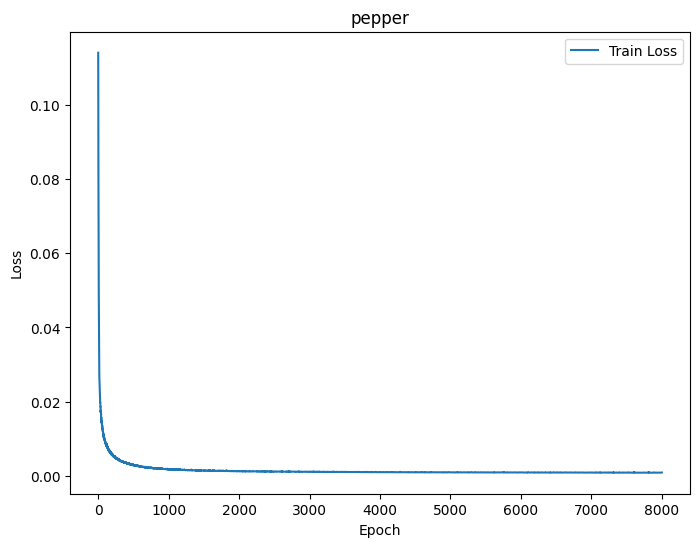

(352, 288)
(512, 512)
Hello
Inside Resize func
Size :  (352, 288)
(352, 288)
[Errno 17] File exists: './drive/MyDrive/SMAI_Project/coastguard'

---------------------------coastguard---------------------------


iteration no.: 0 ,loss : 0.095446
iteration no.: 500 ,loss : 0.004080
iteration no.: 1000 ,loss : 0.003303
iteration no.: 1500 ,loss : 0.002677
iteration no.: 2000 ,loss : 0.002373
iteration no.: 2500 ,loss : 0.002103
iteration no.: 3000 ,loss : 0.001932
iteration no.: 3500 ,loss : 0.001868
iteration no.: 4000 ,loss : 0.001756
iteration no.: 4500 ,loss : 0.001781
iteration no.: 5000 ,loss : 0.001572
iteration no.: 5500 ,loss : 0.001501
iteration no.: 6000 ,loss : 0.001464
iteration no.: 6500 ,loss : 0.001435
iteration no.: 7000 ,loss : 0.001402
iteration no.: 7500 ,loss : 0.001364
iteration no.: 8000 ,loss : 0.001333


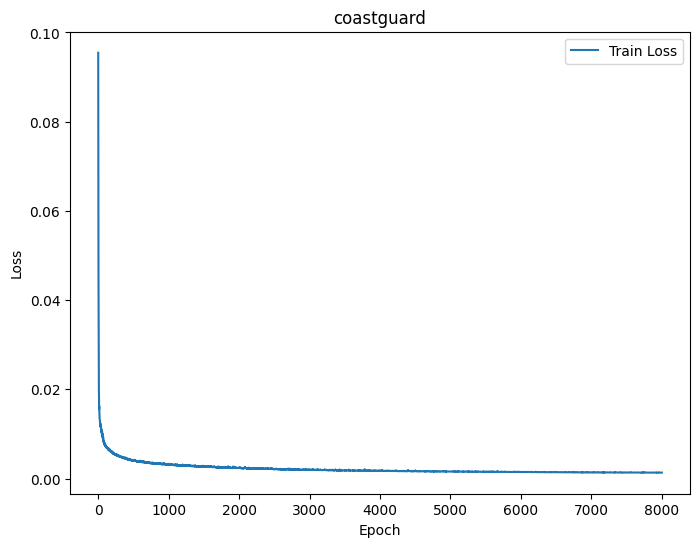

(512, 512)
(512, 512)
Hello
(512, 512)
[Errno 17] File exists: './drive/MyDrive/SMAI_Project/man'

---------------------------man---------------------------


iteration no.: 0 ,loss : 0.101989
iteration no.: 500 ,loss : 0.005007
iteration no.: 1000 ,loss : 0.003353
iteration no.: 1500 ,loss : 0.002771
iteration no.: 2000 ,loss : 0.002371
iteration no.: 2500 ,loss : 0.002330
iteration no.: 3000 ,loss : 0.002097
iteration no.: 3500 ,loss : 0.001971
iteration no.: 4000 ,loss : 0.001889
iteration no.: 4500 ,loss : 0.001842
iteration no.: 5000 ,loss : 0.001761
iteration no.: 5500 ,loss : 0.001742
iteration no.: 6000 ,loss : 0.001669
iteration no.: 6500 ,loss : 0.001569
iteration no.: 7000 ,loss : 0.001544
iteration no.: 7500 ,loss : 0.001511
iteration no.: 8000 ,loss : 0.001502


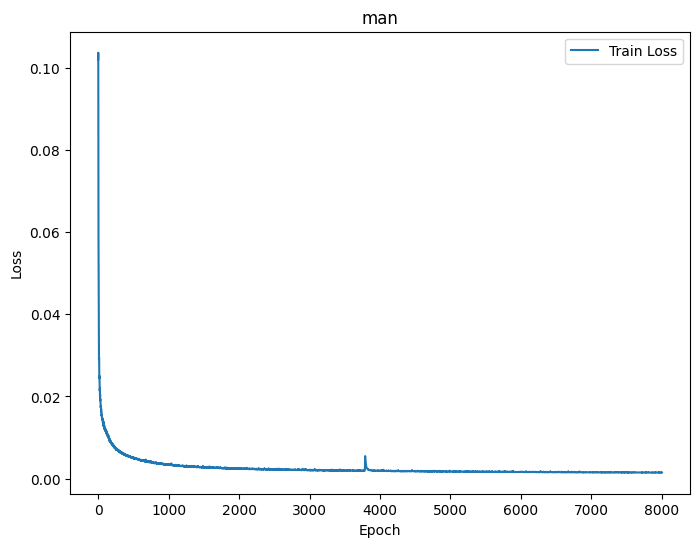

(512, 512)
(512, 512)
Hello
(512, 512)

---------------------------bridge---------------------------


iteration no.: 0 ,loss : 0.082058
iteration no.: 500 ,loss : 0.006884
iteration no.: 1000 ,loss : 0.005056
iteration no.: 1500 ,loss : 0.004317
iteration no.: 2000 ,loss : 0.003901
iteration no.: 2500 ,loss : 0.003476
iteration no.: 3000 ,loss : 0.003327
iteration no.: 3500 ,loss : 0.003084
iteration no.: 4000 ,loss : 0.002879
iteration no.: 4500 ,loss : 0.002770
iteration no.: 5000 ,loss : 0.002715
iteration no.: 5500 ,loss : 0.002628
iteration no.: 6000 ,loss : 0.002485
iteration no.: 6500 ,loss : 0.002514
iteration no.: 7000 ,loss : 0.002408
iteration no.: 7500 ,loss : 0.002344
iteration no.: 8000 ,loss : 0.002350


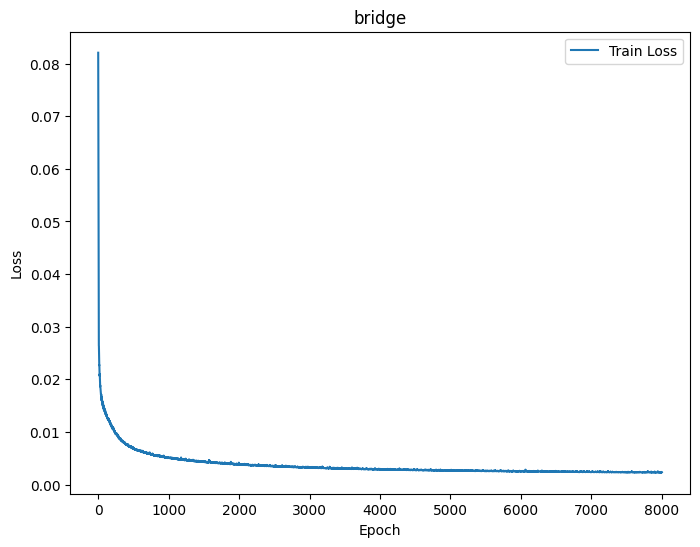

(276, 276)
(512, 512)
Hello
Inside Resize func
Size :  (276, 276)
(276, 276)

---------------------------face---------------------------


iteration no.: 0 ,loss : 0.122969
iteration no.: 500 ,loss : 0.001877
iteration no.: 1000 ,loss : 0.001390
iteration no.: 1500 ,loss : 0.001196
iteration no.: 2000 ,loss : 0.001107
iteration no.: 2500 ,loss : 0.001003
iteration no.: 3000 ,loss : 0.000970
iteration no.: 3500 ,loss : 0.000927
iteration no.: 4000 ,loss : 0.000901
iteration no.: 4500 ,loss : 0.000862
iteration no.: 5000 ,loss : 0.000844
iteration no.: 5500 ,loss : 0.000825
iteration no.: 6000 ,loss : 0.000803
iteration no.: 6500 ,loss : 0.000786
iteration no.: 7000 ,loss : 0.000773
iteration no.: 7500 ,loss : 0.000772
iteration no.: 8000 ,loss : 0.000756


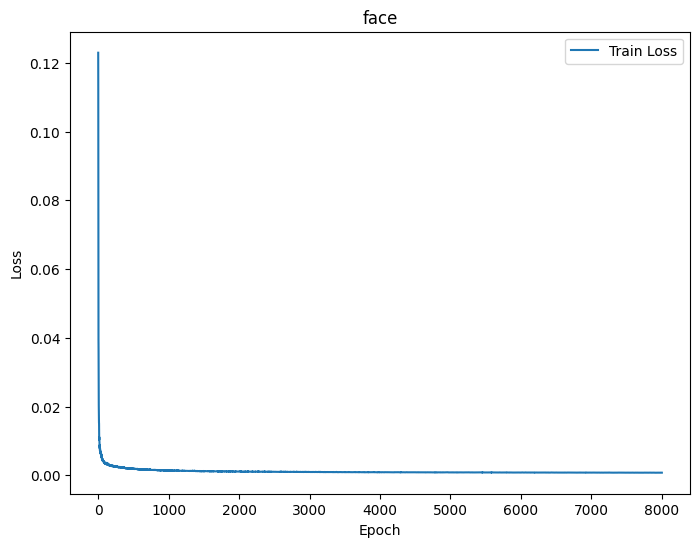

(529, 656)
(512, 512)
Hello
Inside Resize func
Size :  (529, 656)
(529, 656)

---------------------------ppt3---------------------------


iteration no.: 0 ,loss : 0.215566
iteration no.: 500 ,loss : 0.010097
iteration no.: 1000 ,loss : 0.005524
iteration no.: 1500 ,loss : 0.003595
iteration no.: 2000 ,loss : 0.002742
iteration no.: 2500 ,loss : 0.002362
iteration no.: 3000 ,loss : 0.001999
iteration no.: 3500 ,loss : 0.001880
iteration no.: 4000 ,loss : 0.001644
iteration no.: 4500 ,loss : 0.001564
iteration no.: 5000 ,loss : 0.001450
iteration no.: 5500 ,loss : 0.001378
iteration no.: 6000 ,loss : 0.001372
iteration no.: 6500 ,loss : 0.001265
iteration no.: 7000 ,loss : 0.001215
iteration no.: 7500 ,loss : 0.001206
iteration no.: 8000 ,loss : 0.001180


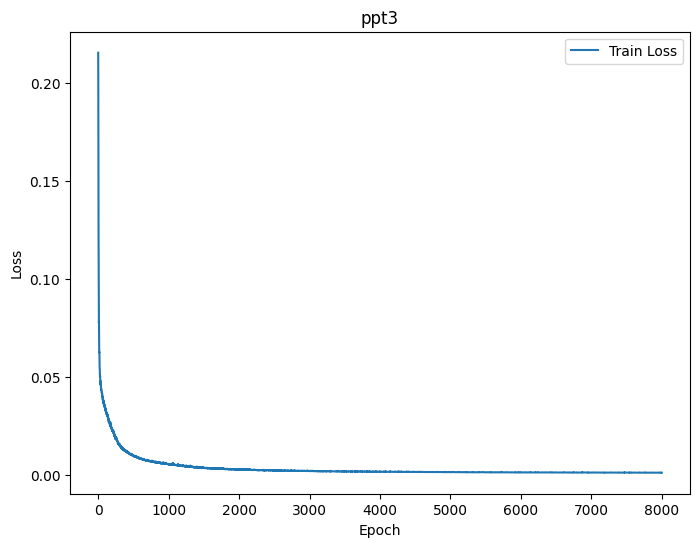

(352, 288)
(512, 512)
Hello
Inside Resize func
Size :  (352, 288)
(352, 288)

---------------------------foreman---------------------------


iteration no.: 0 ,loss : 0.098263
iteration no.: 500 ,loss : 0.002098
iteration no.: 1000 ,loss : 0.001244
iteration no.: 1500 ,loss : 0.001024
iteration no.: 2000 ,loss : 0.000902
iteration no.: 2500 ,loss : 0.000825
iteration no.: 3000 ,loss : 0.000774
iteration no.: 3500 ,loss : 0.000754
iteration no.: 4000 ,loss : 0.000716
iteration no.: 4500 ,loss : 0.000719
iteration no.: 5000 ,loss : 0.000699
iteration no.: 5500 ,loss : 0.000671
iteration no.: 6000 ,loss : 0.000662
iteration no.: 6500 ,loss : 0.000642
iteration no.: 7000 ,loss : 0.000633
iteration no.: 7500 ,loss : 0.000624
iteration no.: 8000 ,loss : 0.000619


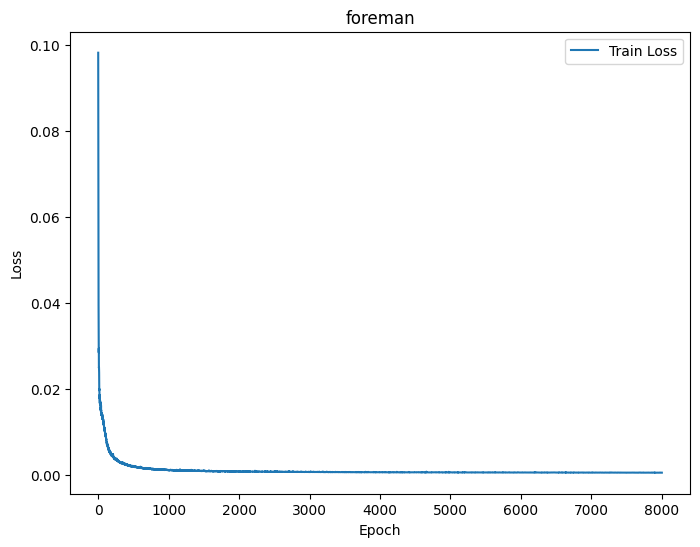

(500, 362)
(512, 512)
Hello
Inside Resize func
Size :  (500, 362)
(500, 362)

---------------------------flowers---------------------------


iteration no.: 0 ,loss : 0.120084
iteration no.: 500 ,loss : 0.006016
iteration no.: 1000 ,loss : 0.004005
iteration no.: 1500 ,loss : 0.003158
iteration no.: 2000 ,loss : 0.002657
iteration no.: 2500 ,loss : 0.002431
iteration no.: 3000 ,loss : 0.002042
iteration no.: 3500 ,loss : 0.001931
iteration no.: 4000 ,loss : 0.001813
iteration no.: 4500 ,loss : 0.001647
iteration no.: 5000 ,loss : 0.001649
iteration no.: 5500 ,loss : 0.001519
iteration no.: 6000 ,loss : 0.001450
iteration no.: 6500 ,loss : 0.001366
iteration no.: 7000 ,loss : 0.001320
iteration no.: 7500 ,loss : 0.001278
iteration no.: 8000 ,loss : 0.001264


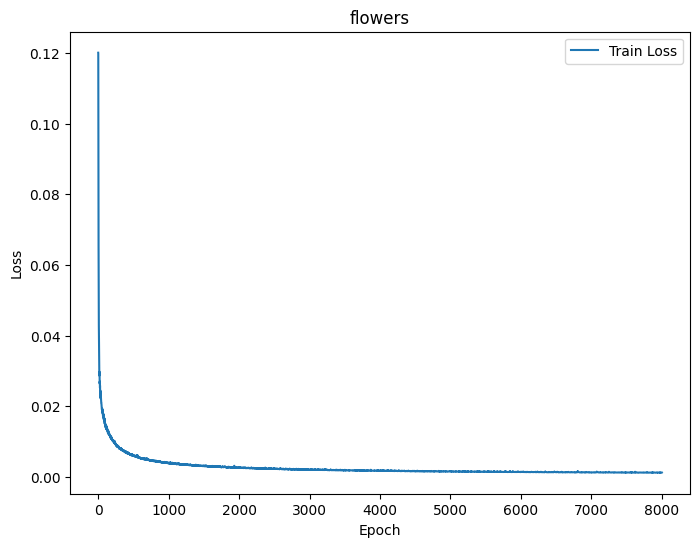

(586, 391)
(512, 512)
Hello
Inside Resize func
Size :  (586, 391)
(586, 391)
[Errno 17] File exists: './drive/MyDrive/SMAI_Project/zebra'

---------------------------zebra---------------------------


iteration no.: 0 ,loss : 0.082924
iteration no.: 500 ,loss : 0.005591
iteration no.: 1000 ,loss : 0.003396
iteration no.: 1500 ,loss : 0.002686
iteration no.: 2000 ,loss : 0.002192
iteration no.: 2500 ,loss : 0.001819
iteration no.: 3000 ,loss : 0.001706
iteration no.: 3500 ,loss : 0.001480
iteration no.: 4000 ,loss : 0.001400
iteration no.: 4500 ,loss : 0.001316
iteration no.: 5000 ,loss : 0.001218
iteration no.: 5500 ,loss : 0.001138
iteration no.: 6000 ,loss : 0.001109
iteration no.: 6500 ,loss : 0.001038
iteration no.: 7000 ,loss : 0.001078
iteration no.: 7500 ,loss : 0.001042
iteration no.: 8000 ,loss : 0.000969


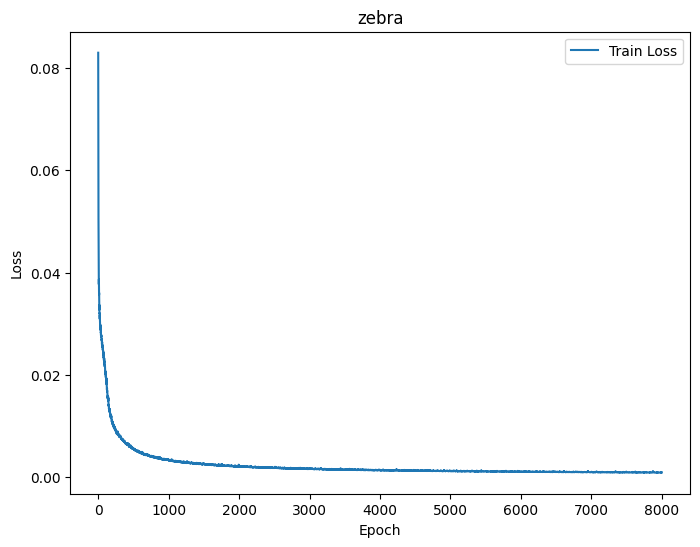

(250, 361)
(512, 512)
Hello
Inside Resize func
Size :  (250, 361)
(250, 361)

---------------------------comic---------------------------


iteration no.: 0 ,loss : 0.101063
iteration no.: 500 ,loss : 0.010033
iteration no.: 1000 ,loss : 0.006800
iteration no.: 1500 ,loss : 0.005702
iteration no.: 2000 ,loss : 0.004975
iteration no.: 2500 ,loss : 0.004376
iteration no.: 3000 ,loss : 0.004086
iteration no.: 3500 ,loss : 0.003798
iteration no.: 4000 ,loss : 0.003537
iteration no.: 4500 ,loss : 0.003389
iteration no.: 5000 ,loss : 0.003220
iteration no.: 5500 ,loss : 0.003076
iteration no.: 6000 ,loss : 0.003012
iteration no.: 6500 ,loss : 0.002950
iteration no.: 7000 ,loss : 0.002871
iteration no.: 7500 ,loss : 0.002791
iteration no.: 8000 ,loss : 0.002761


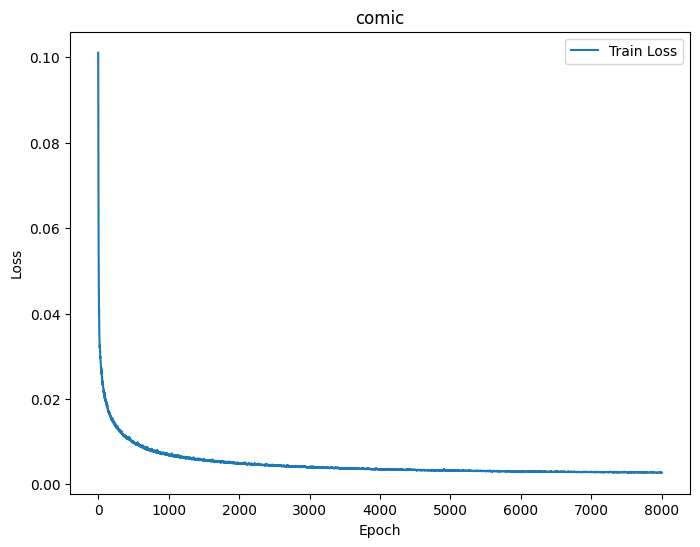

(768, 512)
(512, 512)
Hello
Inside Resize func
Size :  (768, 512)
(768, 512)

---------------------------monarch---------------------------


iteration no.: 0 ,loss : 0.066105
iteration no.: 500 ,loss : 0.003680
iteration no.: 1000 ,loss : 0.001897
iteration no.: 1500 ,loss : 0.001377
iteration no.: 2000 ,loss : 0.001121
iteration no.: 2500 ,loss : 0.000992
iteration no.: 3000 ,loss : 0.000860
iteration no.: 3500 ,loss : 0.000805
iteration no.: 4000 ,loss : 0.008133
iteration no.: 4500 ,loss : 0.001585
iteration no.: 5000 ,loss : 0.001205
iteration no.: 5500 ,loss : 0.001022
iteration no.: 6000 ,loss : 0.000881
iteration no.: 6500 ,loss : 0.000820
iteration no.: 7000 ,loss : 0.000863
iteration no.: 7500 ,loss : 0.000725
iteration no.: 8000 ,loss : 0.000716


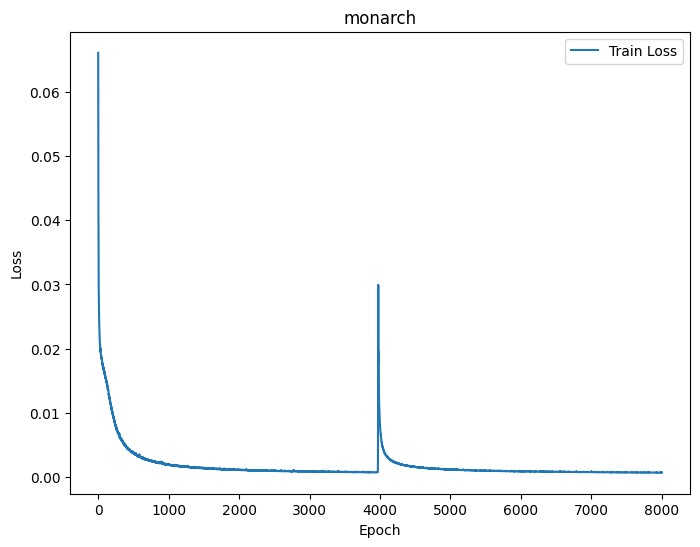

(500, 480)
(512, 512)
Hello
Inside Resize func
Size :  (500, 480)
(500, 480)

---------------------------baboon---------------------------


iteration no.: 0 ,loss : 0.107913
iteration no.: 500 ,loss : 0.011518
iteration no.: 1000 ,loss : 0.009736
iteration no.: 1500 ,loss : 0.008705
iteration no.: 2000 ,loss : 0.008071
iteration no.: 2500 ,loss : 0.007555
iteration no.: 3000 ,loss : 0.007237
iteration no.: 3500 ,loss : 0.006963
iteration no.: 4000 ,loss : 0.006675
iteration no.: 4500 ,loss : 0.006496
iteration no.: 5000 ,loss : 0.006276
iteration no.: 5500 ,loss : 0.006557
iteration no.: 6000 ,loss : 0.006163
iteration no.: 6500 ,loss : 0.005982
iteration no.: 7000 ,loss : 0.005880
iteration no.: 7500 ,loss : 0.005735
iteration no.: 8000 ,loss : 0.005603


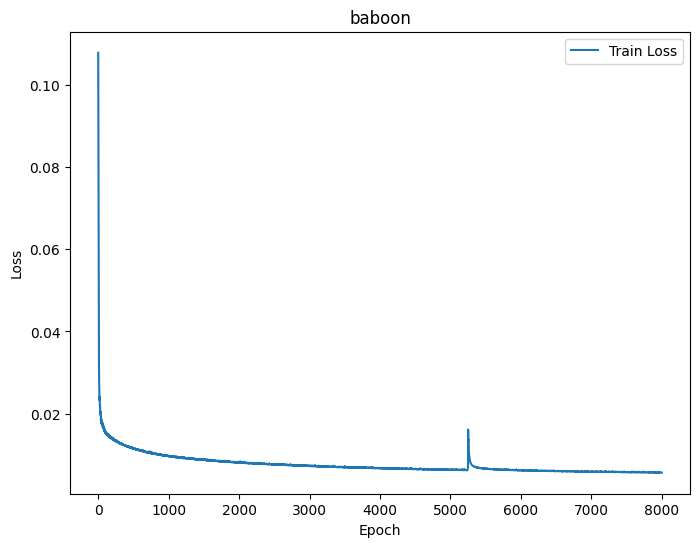

(720, 576)
(512, 512)
Hello
Inside Resize func
Size :  (720, 576)
(720, 576)

---------------------------barbara---------------------------


iteration no.: 0 ,loss : 0.102153
iteration no.: 500 ,loss : 0.006337
iteration no.: 1000 ,loss : 0.004415
iteration no.: 1500 ,loss : 0.003924
iteration no.: 2000 ,loss : 0.003609
iteration no.: 2500 ,loss : 0.003445
iteration no.: 3000 ,loss : 0.003268
iteration no.: 3500 ,loss : 0.003130
iteration no.: 4000 ,loss : 0.002984
iteration no.: 4500 ,loss : 0.002882
iteration no.: 5000 ,loss : 0.002788
iteration no.: 5500 ,loss : 0.002729
iteration no.: 6000 ,loss : 0.002700
iteration no.: 6500 ,loss : 0.002646
iteration no.: 7000 ,loss : 0.002637
iteration no.: 7500 ,loss : 0.002538
iteration no.: 8000 ,loss : 0.002537


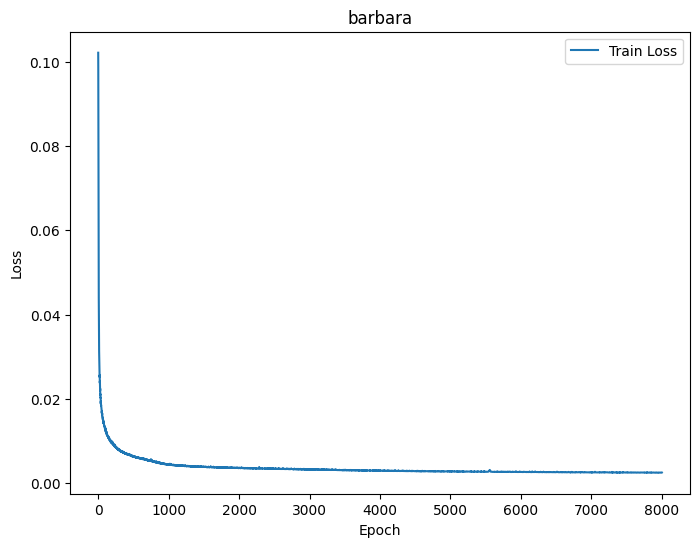

(512, 512)
(512, 512)
Hello
(512, 512)

---------------------------lenna---------------------------


iteration no.: 0 ,loss : 0.080959
iteration no.: 500 ,loss : 0.002242
iteration no.: 1000 ,loss : 0.001503
iteration no.: 1500 ,loss : 0.001217
iteration no.: 2000 ,loss : 0.001076
iteration no.: 2500 ,loss : 0.000977
iteration no.: 3000 ,loss : 0.000896
iteration no.: 3500 ,loss : 0.000870
iteration no.: 4000 ,loss : 0.000785
iteration no.: 4500 ,loss : 0.000745
iteration no.: 5000 ,loss : 0.000739
iteration no.: 5500 ,loss : 0.000726
iteration no.: 6000 ,loss : 0.000672
iteration no.: 6500 ,loss : 0.000648
iteration no.: 7000 ,loss : 0.000637
iteration no.: 7500 ,loss : 0.000637
iteration no.: 8000 ,loss : 0.000605


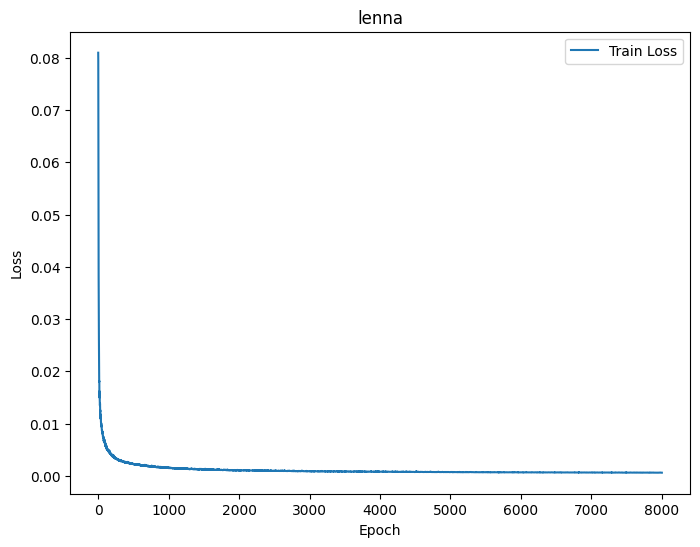

IsADirectoryError: ignored

In [ ]:
image_mask = "mask.png"

for image in file_list:
  # image_path = 'zebra.png'
  ## experiment options

  
  sigma = 1. / 30
  input_channel = 3
  num_iter = 8000
  lr = 0.01

  ### load data
  img = load_img(image)
  print(img.size)
  w,h = img.size 
  x = ChangeImage(img)
  img2 = load_img('./kate_mask.png')
  print(img2.size)
  resize_image(img2,w,h)
  
  mask = load_img(image_mask)
  print(mask.size)

  mask = ChangeImage(mask)
  # x = add_noise(x,25 / 255.)
  words = image.split('/')
  imm = words[-1].split('.')[0]
  full_path = './drive/MyDrive/SMAI_Project/{}'.format(imm)
  try:
    os.mkdir(full_path) 
  except OSError as error: 
    print(error)  
  print("\n---------------------------{}---------------------------".format(imm))
  original = x * mask
  array_to_img(original[0]).save('{}/noise.png'.format(full_path))
  layers = model_obj(original)
  b, w, h, c = original.shape
  mod = layers.model_structure()
  #----------------------------------------------------------
  input = mod.input
  mask_input = Input((w, h, c))
  y = mod.output
  output = multiply([y, mask_input])
  model = Model(inputs=[input, mask_input], outputs=output,name='trainer')
#----------------------------------------------------------
  model.compile(optimizer=Adam(lr=lr), loss=mse)
  # model.summary()

  train_loss = []
  z = np.random.uniform(0, 0.1, size=(1,w,h,input_channel))
  losses = []
  for i in range(num_iter+1):
      with tf.device('/GPU:0'):
        temp = z + np.random.normal(0, sigma, size = z.shape)
        loss = model.train_on_batch([temp, mask], original)
        train_loss.append(loss)
        if i % 500 == 0:
            print('iteration no.: %d ,loss : %f' % (i, loss))
            y = mod.predict_on_batch(z)
            array_to_img(y[0]).save('{}/{}.png'.format(full_path, i))

  plot_losses(train_loss, imm)